In [7]:
import pandas as pd
import matplotlib.pyplot as plt

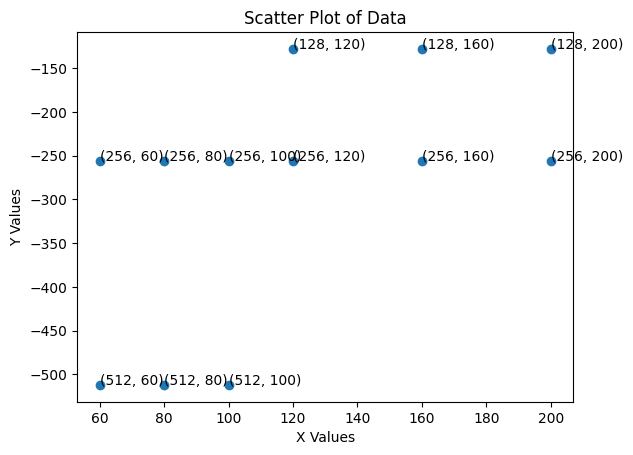

In [25]:
import matplotlib.pyplot as plt

# Set up the data
data = {
    (128, 120): (0, 0),
    (128, 160): (0, 0),
    (128, 200): (0, 0),
    (256, 60): (38, -66),
    (256, 80): (38, -16),
    (256, 100): (38, -66),
    (256, 120): (38, 0),
    (256, 160): (38, 0),
    (256, 200): (38, 62),
    (512, 60): (114, -66),
    (512, 80): (114, -66),
    (512, 100): (114, -66),
}

# Extract the x and y values from the data
x_values = [key[1] for key in data.keys()]
y_values = [-key[0] for key in data.keys()] # Negate the y-values to match the coordinate system

# Extract the point labels from the data
point_labels = [str(key) for key in data.keys()]

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_values, y_values)

# Add labels to the points
for i, label in enumerate(point_labels):
    ax.annotate(label, (x_values[i], y_values[i]))

# Set the plot title and axis labels
ax.set_title('Scatter Plot of Data')
ax.set_xlabel('X Values')
ax.set_ylabel('Y Values')

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


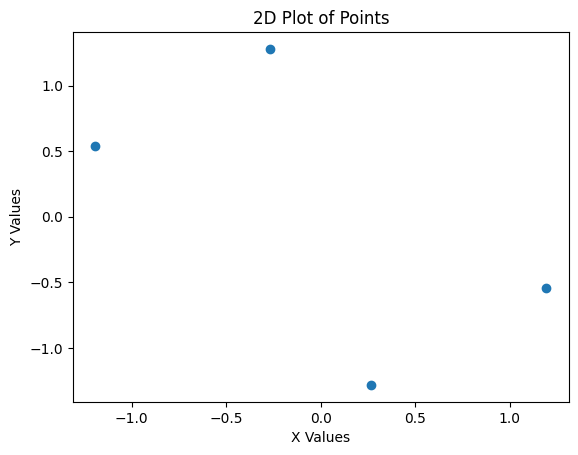

In [27]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Define the pairwise distances between the points
distances = np.array([[0, 1, 2, 3],
                      [1, 0, 3, 2],
                      [2, 3, 0, 1],
                      [3, 2, 1, 0]])

# Apply MDS to the pairwise distances to get the coordinates of the points in 2D
mds = MDS(n_components=2, dissimilarity='precomputed')
points_2d = mds.fit_transform(distances)

# Plot the points in 2D
fig, ax = plt.subplots()
ax.scatter(points_2d[:,0], points_2d[:,1])

# Set the plot title and axis labels
ax.set_title('2D Plot of Points')
ax.set_xlabel('X Values')
ax.set_ylabel('Y Values')

# Show the plot
plt.show()

In [ ]:
# originalfile_path
import os 
ROOT_DIR = os.environ['ROOT_DIR']
assert os.path.exists(ROOT_DIR), "ROOT_DIR does not exist"
file_name_prefix = "sols_opt_66b_Tesla_V100-SXM2-32GB_2_NVIDIA_A100-SXM4-40GB_2"
folder_path = f"{ROOT_DIR}/scripts/part_strategy/{file_name_prefix}"
available_bits = [3, 4, '8:tc-li', 16]
# 
interested_file_names = [
    "lat_gamma_0.6",
    "lat_gamma_0.8",
    "lat",
    "group_s_256_n_200_gamma_0.6",
    "group_s_256_n_200_gamma_0.8",
    "group_s_256_n_200_gamma_1",
    "group_s_256_n_100_gamma_0.6",
    "group_s_256_n_100_gamma_0.8",
    "group_s_256_n_100_gamma_1",
    "group_gamma_0.6",
    "group_gamma_0.8",
    "group_1",
]
import pickle
# load data
data_dict = {}
test_method = 'shaq'
for key in interested_file_names:
    path = f"{folder_path}{key}.pkl"
    assert os.path.exists(path), f"{path} does not exist"
    with open(path, "rb") as f:
        data = pickle.load(f)
        # get bitassignment
        bit_assignment = data[test_method]['plan']['bit_assignment']
        bit_val = list(bit_assignment.values())
        bit_val = [available_bits.index(val) for val in bit_val]
        data_dict[key] = bit_val

# update keys
key_mapping = {
    "lat_gamma_0.6": "(128, 120 | 200)",
    "lat_gamma_0.8": "(128, 160 | 200)",
    "lat": "(128, 180 | 200)",
    "group_s_256_n_200_gamma_0.6": "(256, 120 | 200)",
    "group_s_256_n_200_gamma_0.8": "(256, 160 | 200)",
    "group_s_256_n_200_gamma_1": "(256, 200 | 200)",
    "group_s_256_n_100_gamma_0.6": "(256, 60 | 100)",
    "group_s_256_n_100_gamma_0.8": "(256, 80 | 100)",
    "group_s_256_n_100_gamma_1": "(256, 100 | 100)",
    "group_gamma_0.6": "(512, 60 | 100)",
    "group_gamma_0.8": "(512, 80 | 100)",
    "group_1": "(512, 100 | 100)",
}
# update keys
data_dict_new = {}
for key in data_dict:
    data_dict_new[key_mapping[key]] = data_dict[key]
data_dict = data_dict_new

# calculate dissimilarity
# KL divergence of bitwidth distribution
# [1, 0, 1, 2], [1, 0, 1, 2], etc.
# use hamming and cosine
import numpy as np
from scipy.spatial.distance import cosine
from scipy.spatial.distance import hamming
def kl_divergence(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
# calculte distance between different keys(pairwise)
keys = list(data_dict.keys())
keys.sort()
# calculate distance
distance_matrix = np.zeros((len(keys), len(keys)))
for i in range(len(keys)):
    for j in range(len(keys)):
        key_i = keys[i]
        key_j = keys[j]
        distance_matrix[i, j] = hamming(data_dict[key_i], data_dict[key_j])
        # distance_matrix[i, j] = kl_divergence(data_dict[key_i], data_dict[key_j])
        # distance_matrix[i, j] = cosine(data_dict[key_i], data_dict[key_j])
# print

In [65]:
def generate_point_dict(seed=32):
    # use MDS to visualize
    from sklearn.manifold import MDS
    embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=seed)
    X_transformed = embedding.fit_transform(distance_matrix)
    # plot
    import matplotlib.pyplot as plt
    # define a threshold for determining whether two points should be considered the same
    threshold = 0.1
    
    # create a dictionary to keep track of points with the same x and y values
    point_dict = {}
    
    # iterate over all transformed points and their corresponding keys
    for i in range(len(keys)):
        point = tuple(X_transformed[i])  # convert the transformed point to a tuple
        label = keys[i]
    
        # check if there's already a point in point_dict that's within the threshold distance of this point
        match_found = False
        for existing_point in point_dict:
            dist = ((existing_point[0]-point[0])**2 + (existing_point[1]-point[1])**2)**0.5
            if dist < threshold:
                # if a match is found, concatenate the existing label with the new label
                point_dict[existing_point] += f", {label}"
                match_found = True
                break
    
        # if no match was found, add the new point to point_dict with its label as the value
        if not match_found:
            point_dict[point] = label
    return point_dict

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


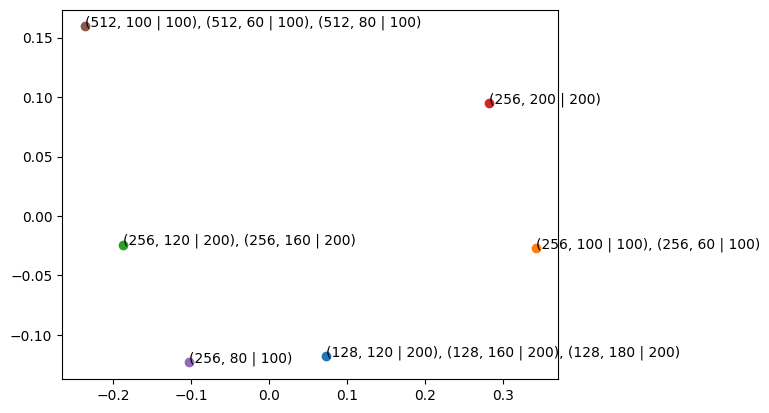

In [106]:
point_dict = generate_point_dict(seed=35)
# create a list of unique transformed points and their concatenated labels
unique_points = []
for point, label in point_dict.items():
    unique_points.append((point, label))
    
# plot the unique points
for point, label in unique_points:
    plt.text(point[0], point[1], label)
    plt.scatter(point[0], point[1])
plt.show()




In [ ]:
35